# Taxi Travel Data Analysis

In this demo, we will be doing some demos on temporal feature engineering with the Kaggle Dataset

### Loading libraries, datasets

In [23]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch

In [24]:
# These are all of the files you are given
#df_tr = pd.read_csv("archive/train.csv")


In [25]:
#df_tr.head()
# avg = df_tr['LEN'].mean()
# print(avg)

### Get Computed Time from POLYLINE

Our goal is to predict the travel-time of the taxi, which can be derived from the POLYLINE length.

Recall:

```
The travel time of the trip (the prediction target of this project) is defined as the (number of points-1) x 15 seconds. 
For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds. Some trips have missing 
data points in POLYLINE, indicated by MISSING_DATA column, and it is part of the challenge how you utilize this knowledge.
```

We are not doing anything with the MISSING_DATA. It is up to you to find a way to use (or ignore) that information.

In [26]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
# df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [27]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
# df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
def parse_midnight_minutes(x):
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.hour * 60 + dt.minute

In [28]:
def onehot(x):
    x=x.values[0]
    if x=="A":
        return 1, 0, 0
    elif x=="B":
        return 0, 1, 0
    elif x=="C":
        return 0, 0, 1
    else:
        return 0, 0, 0
    
# df_tr[["CALL_A", "CALL_B", "CALL_C"]] = df_tr[["CALL_TYPE"]].apply(onehot, axis=1, result_type="expand")   
# df_tr[["DAY_A", "DAY_B", "DAY_C"]] = df_tr[["DAY_TYPE"]].apply(onehot, axis=1, result_type="expand")     


### Create a Prediction File

In [29]:
# vals = df_tr["HR"].value_counts()
# print(vals)
# def reduce(x):
#     return x - 2013
# hr_oh = torch.nn.functional.one_hot(torch.tensor(df_tr["HR"].values))
# print(hr_oh)
# print(hr_oh.shape)

In [30]:
# vals = df_tr["TAXI_ID"].values
# print(vals)
# print(min(vals))
# print(max(vals))

# # df_tr["TAXI_ID"] = df_tr["TAXI_ID"].apply(reduce)
# vals = df_tr["TAXI_ID"].values
# print(vals)
# print(min(vals))
# print(max(vals))
# oh = torch.nn.functional.one_hot(torch.tensor(df_tr["TAXI_ID"].values))
# print(oh)
# print(oh.shape)


In [31]:
# df_tr[["CALL_A", "LEN"]].values

In [32]:
# Feature Trimming
# mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
# median = df_tr["LEN"].median()
# outlier_threshold = 3
# df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]
# df_trimmed = df_trimmed[df_trimmed['MISSING_DATA'] == False]
# print("Before Trimming: " + str(len(df_tr)))
# print("After Trimming: " + str(len(df_trimmed)))

# df_tr = df_trimmed

In [33]:
df_tr = pd.read_csv("archive/train.csv")
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)
mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
outlier_threshold = 3
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]
df_trimmed = df_trimmed[df_trimmed['MISSING_DATA'] == False]
df_trimmed = df_trimmed[df_trimmed['LEN'] != 0]
print("Before Trimming: " + str(len(df_tr)))
print("After Trimming: " + str(len(df_trimmed)))
df_tr = df_trimmed



trlen = len(df_tr)

df_ts = pd.read_csv("archive/test_public.csv")
df_ts["POLYLINE"]="trololololo"


df_both = pd.concat([df_tr, df_ts])
df_both["LEN"] = df_both["POLYLINE"].apply(polyline_to_trip_duration)
ocvc = df_both["ORIGIN_CALL"].value_counts()
def filterOC(x):
    if pd.isnull(x):
        return x
    if(ocvc[x] < 200):
        return None
    return x
df_both["ORIGIN_CALL"] = df_both["ORIGIN_CALL"].apply(filterOC)
print(df_both["ORIGIN_CALL"].value_counts())
# # df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
df_both["MIDMINS"] = df_both[["TIMESTAMP"]].apply(parse_midnight_minutes, axis=1, result_type="expand")
#df_tr["MIDMINS"]=(df_tr["MIDMINS"]-df_tr["MIDMINS"].min())/(df_tr["MIDMINS"].max()-df_tr["MIDMINS"].min())
df_both = pd.get_dummies(data=df_both, columns=['CALL_TYPE', "ORIGIN_STAND", "ORIGIN_CALL"])


df_tr = df_both.iloc[:trlen]
df_ts = df_both.iloc[trlen:]






Before Trimming: 1710670
After Trimming: 1656255
2002.0     56688
63882.0     6320
2001.0      2397
13168.0     1290
6728.0      1089
           ...  
34861.0      209
6715.0       206
18820.0      206
15356.0      201
15420.0      201
Name: ORIGIN_CALL, Length: 68, dtype: int64


In [34]:

class MyDataset(Dataset):
  def __init__(self, df):

    boolcols = list(df.columns)
    badcols = ["TRIP_ID", 'MIDMINS',  'TIMESTAMP', 'MISSING_DATA', 'POLYLINE', 'LEN', "TAXI_ID", "DAY_TYPE"] 
    for b in badcols:
      boolcols.remove(b)
    # print(boolcols)
    
    
         
    boolz=df[boolcols].values
    intz = df["MIDMINS"].values
    # print(boolz)
    y=df["LEN"].values

    booltens = torch.tensor(boolz,dtype=torch.float32)
    inttens = torch.tensor(intz,dtype=torch.float32).unsqueeze(1)

    # print(booltens.shape)
    # print(inttens.shape)
 
    self.x_train=torch.cat([booltens, inttens], dim=1)
    # print(self.x_train)
    self.y_train=torch.tensor(y,dtype=torch.float32)
    self.df = df
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [35]:
from torch.utils.data import random_split
trds=MyDataset(df_tr)
# trds, valds = random_split(trds, [0.9, 0.1])
# print(len(trds), len(valds))
train_loader=DataLoader(trds,batch_size=256, shuffle=True)
# val_loader=DataLoader(valds)

In [36]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten(start_dim=1)
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        self.dro = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(135, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):

        
        x = F.relu(self.fc1(x))
        x = self.dro(x)
        x = F.relu(self.fc2(x))
        # x = self.dro(x)
        x = F.relu(self.fc3(x))
        # x = self.dro(x)
        x = self.fc4(x)
        # x = torch.transpose(x, 0, 1)
        return x


net = Net()

In [37]:
import torch.optim as optim
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))
criterion = RMSELoss
optimizer = optim.Adam(net.parameters(), lr=0.00001)

In [82]:
losses = []
total_loss = 0.0
iter = 0
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        iter += 1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        labels=labels.unsqueeze(1)
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_loss += loss.item()
        losses.append(total_loss / iter)
        if i % 2000 == 1999:    # print every 2000 mini-batches
            #print(outputs[0], labels[0])
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
    print("Epoch: " + str(epoch + 1) + ", steps:" + str(iter))
    # epoch_loss = 0.0

print('Finished Training')
print(len(losses))


[1,  2000] loss: 484.129
[1,  4000] loss: 453.523
[1,  6000] loss: 424.145
[1,  6470] loss: 96.645
Epoch: 1, steps:6470
[2,  2000] loss: 405.112
[2,  4000] loss: 397.786
[2,  6000] loss: 395.322
[2,  6470] loss: 93.050
Epoch: 2, steps:12940
[3,  2000] loss: 393.905
[3,  4000] loss: 392.123
[3,  6000] loss: 391.394
[3,  6470] loss: 91.733
Epoch: 3, steps:19410
[4,  2000] loss: 390.579
[4,  4000] loss: 389.991
[4,  6000] loss: 390.589
[4,  6470] loss: 91.959
Epoch: 4, steps:25880
[5,  2000] loss: 390.465
[5,  4000] loss: 390.346
[5,  6000] loss: 388.352
[5,  6470] loss: 91.447
Epoch: 5, steps:32350
Finished Training
32350


[766.5413208007812, 667.6160888671875, 767.7797241210938, 634.6720581054688, 725.2482299804688, 712.5795288085938, 767.0057373046875, 707.9356079101562, 745.2899169921875, 769.1729736328125, 600.3084716796875, 731.551513671875, 731.0870971679688, 738.421142578125, 732.9447021484375, 734.6474609375, 731.8611450195312, 733.4090576171875, 767.3152465820312, 737.124267578125, 766.3865966796875, 707.7808837890625, 709.622802734375, 766.2317504882812, 658.4505004882812, 732.4895629882812, 767.0057373046875, 766.2317504882812, 636.6326293945312, 767.6249389648438, 767.9345092773438, 667.1516723632812, 732.3255004882812, 730.9323120117188, 732.7899169921875, 736.9694213867188, 864.7465209960938, 594.0904541015625, 766.3865966796875, 648.3621215820312, 633.3643798828125, 731.0870971679688, 732.3255004882812, 745.9091796875, 626.0264282226562, 631.1588745117188, 732.015869140625, 731.551513671875, 572.9459838867188, 600.1536254882812, 621.6449584960938, 678.3794555664062, 593.7809448242188, 767.

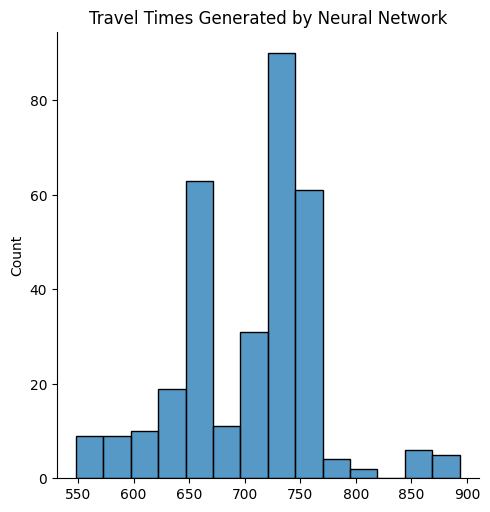

In [138]:
import seaborn as sns
testset = MyDataset(df_ts)
testloader = DataLoader(testset)
preds = []
with torch.no_grad():
    for data in testloader:
        features, labels = data
        # calculate outputs by running images through the network
        output = net(features)
        preds.append(output.item())
ids = testset.df["TRIP_ID"]        
print(preds)
d = {"TRIP_ID" : ids, "TRAVEL_TIME" : preds}
newdf = pd.DataFrame(d)
print(newdf)
newdf.to_csv("my_pred.csv", index=None)
labels = preds
# print(labels)
print('mean', np.mean(labels))
print('std', np.std(labels))
print('median', np.median(labels))
print('min', np.min(labels))
print('max', np.max(labels))
print('----------')
sns.displot(labels).set(title='Travel Times Generated by Neural Network')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


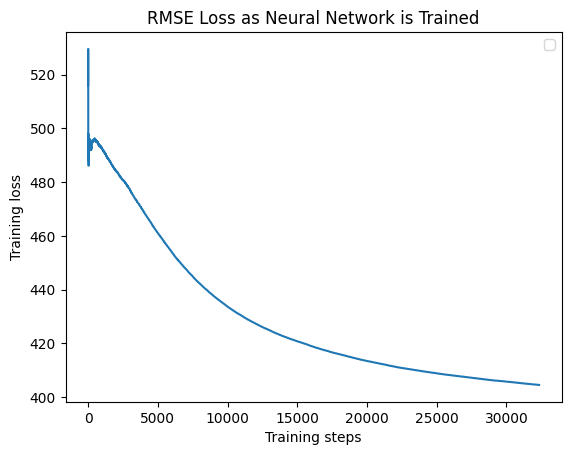

In [89]:
xRange = range(1, len(losses) + 1)

plt.plot(xRange, losses)

plt.xlabel("Training steps")
plt.ylabel("Training loss")
plt.title("RMSE Loss as Neural Network is Trained")
plt.legend()
plt.show()

tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0200e+03],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0280e+03],
        [0.0000e+00, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0220e+03],
        ...,
        [0.0000e+00, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         9.9600e+02],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         5.0300e+02],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         7.5900e+02]])

In [78]:
import ast
net.eval()
# Create a list to store the losses
data_point_losses = []

# Iterate over the dataset and compute the losses
with torch.no_grad():
    print(trds.df.shape)
    for i in range(trds.df.shape[0]):
        if i % 100000 == 0:
            print("i: ", i)
        # print(trds.df[i:i+1])
        input = trds.x_train[i]
        output = net(input)
        label = trds.y_train[i]
        # print(input)
        # print('output: ', output.item())
        # print('label: ', label.item())
        # print('loss: ', criterion(output.item(), label).item())
        loss = criterion(output, label)
        data_point_losses.append(loss.item())  # Append the loss value to the list

# Convert the losses to a tensor
loss_tensor = torch.tensor(data_point_losses)


(1656255, 142)
i:  0
i:  100000
i:  200000
i:  300000
i:  400000
i:  500000
i:  600000
i:  700000
i:  800000
i:  900000
i:  1000000
i:  1100000
i:  1200000
i:  1300000
i:  1400000
i:  1500000
i:  1600000


[[-8.669106, 41.235093], [-8.669178, 41.236551], [-8.669385, 41.238252], [-8.668089, 41.237118], [-8.667459, 41.234994], [-8.666766, 41.232825], [-8.667801, 41.230773], [-8.66853, 41.228127], [-8.669052, 41.225679], [-8.667945, 41.224293], [-8.665596, 41.225652], [-8.661996, 41.225841], [-8.658108, 41.226984], [-8.654913, 41.229216], [-8.653293, 41.23233], [-8.653563, 41.236083], [-8.650467, 41.239143], [-8.646075, 41.240898], [-8.640945, 41.239827], [-8.635563, 41.239629], [-8.630613, 41.241096], [-8.625447, 41.241474], [-8.619714, 41.240142], [-8.613387, 41.239323], [-8.606727, 41.239998], [-8.600049, 41.23962], [-8.593884, 41.237766], [-8.587503, 41.237784], [-8.581401, 41.239008], [-8.575209, 41.239314], [-8.56998, 41.240178], [-8.56773, 41.240475], [-8.567631, 41.240349], [-8.565012, 41.239539], [-8.562465, 41.2407], [-8.56413, 41.242572], [-8.565471, 41.245434], [-8.567442, 41.248683], [-8.568369, 41.253192], [-8.566992, 41.258025], [-8.564274, 41.262921], [-8.561628, 41.267637],

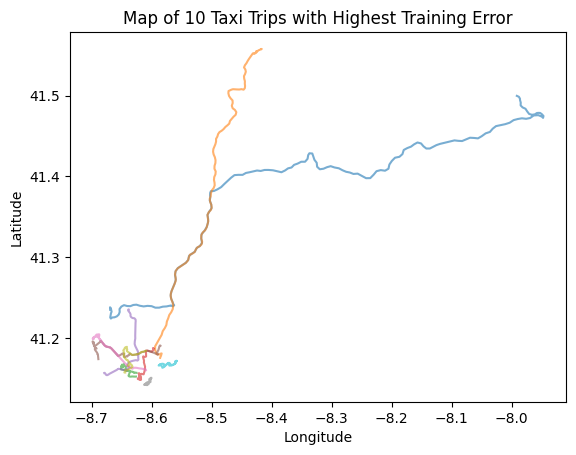

In [88]:
# Find the indices and values of the top 10 highest losses
top_loss_values, top_loss_indices = torch.topk(loss_tensor, k=10, largest=True)

# Print the indices and corresponding losses
for value, index in zip(top_loss_values, top_loss_indices):
    # print("Index:", index.item(), "Loss:", value.item())
    polyline = trds.df[index.item():index.item()+1]['POLYLINE'].values[0]
    polyline_array = ast.literal_eval(polyline)
    longitude_values = [row[0] for row in polyline_array]  # First column elements
    latitude_values = [row[1] for row in polyline_array]  # Second column elements
    print(polyline_array)
    plt.plot(longitude_values, latitude_values, label = str(index.item()), alpha=0.6)

    # print(x_vals)

# plt.plot()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
# plt.legend()
plt.title("Map of 10 Taxi Trips with Highest Training Error")
plt.show()



In [314]:
# with torch.no_grad():
#     total_loss = 0.0
#     for i, data in enumerate(val_loader, 0):

#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data


#         # forward + backward + optimize
#         labels=labels
#         outputs = net(inputs)
        
#         loss = criterion(outputs, labels)


#         # print statistics
#         total_loss += loss.item()
#         # if i%1000==0:
#         #     print(round(loss.item()), outputs, labels)

# print(f'Total Loss: {total_loss / len(val_loader):.3f}')


Total Loss: 635.196


[766.5413208007812, 667.6160888671875, 767.7797241210938, 634.6720581054688, 725.2482299804688, 712.5795288085938, 767.0057373046875, 707.9356079101562, 745.2899169921875, 769.1729736328125, 600.3084716796875, 731.551513671875, 731.0870971679688, 738.421142578125, 732.9447021484375, 734.6474609375, 731.8611450195312, 733.4090576171875, 767.3152465820312, 737.124267578125, 766.3865966796875, 707.7808837890625, 709.622802734375, 766.2317504882812, 658.4505004882812, 732.4895629882812, 767.0057373046875, 766.2317504882812, 636.6326293945312, 767.6249389648438, 767.9345092773438, 667.1516723632812, 732.3255004882812, 730.9323120117188, 732.7899169921875, 736.9694213867188, 864.7465209960938, 594.0904541015625, 766.3865966796875, 648.3621215820312, 633.3643798828125, 731.0870971679688, 732.3255004882812, 745.9091796875, 626.0264282226562, 631.1588745117188, 732.015869140625, 731.551513671875, 572.9459838867188, 600.1536254882812, 621.6449584960938, 678.3794555664062, 593.7809448242188, 767.

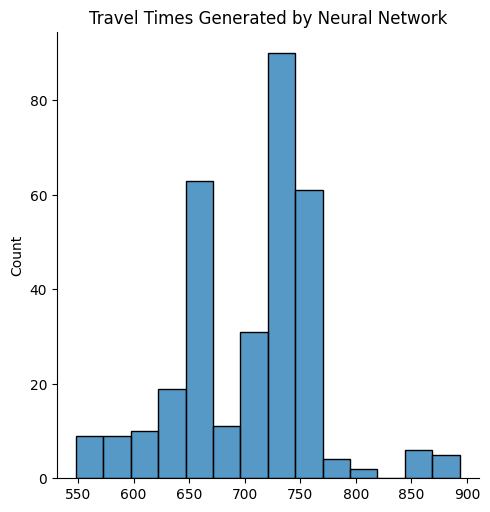

In [316]:
# # Sample submission file that is given on kaggle
# df_sample = pd.read_csv("archive/sampleSubmission.csv")

# df_sample["TRAVEL_TIME"] = 716.43

# # mean(716.43) -> 792.73593
# # median(600) -> 784.74219
# df_sample.to_csv("my_pred.csv", index=None)

**Boosted Decision Trees**


In [93]:
def processCSV(csvname):
  xg_train = pd.read_csv(csvname)
  df_tr = xg_train
  if "POLYLINE" not in df_tr: #test dataset
    df_tr["POLYLINE"]="[[["
    df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)
  else: 
    df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)
    mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
    median = df_tr["LEN"].median()
    outlier_threshold = 3
    print(mean, std)
    df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]
    df_trimmed = df_trimmed[df_trimmed['MISSING_DATA'] == False]
    print("Before Trimming: " + str(len(df_tr)))
    print("After Trimming: " + str(len(df_trimmed)))
    df_tr = df_trimmed
    # first trim the dataset

  df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
  df_tr["MIDMINS"] = df_tr[["TIMESTAMP"]].apply(parse_midnight_minutes, axis=1, result_type="expand")

  LetterToIndex = {'A': 0, 'B': 1, 'C': 2}
  df_trimmed_copy = df_tr
  # print('there was ' + str(len(df_trimmed_copy['LEN'] == 0)) + " zeroes")
  # df_trimmed_copy = df_trimmed_copy[df_trimmed_copy['LEN'] != 0]

  y_train = df_trimmed_copy["LEN"]
  df_trimmed_copy["CALL_TYPE"] = df_trimmed_copy["CALL_TYPE"].map(LetterToIndex)
  # df_trimmed_copy["DAY_TYPE"] = df_trimmed_copy["DAY_TYPE"].map(LetterToIndex)
  #took out "TRIP_ID"
  # x_train = df_trimmed_copy[["TRIP_ID", "CALL_TYPE", "ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID", "YR", "MON", "DAY", "HR", "WK", "MIDMINS"]]
  return df_trimmed_copy, y_train

In [94]:
x_train_unfiltered, y_train = processCSV('archive/train.csv')

716.4264615618442 684.7511617508213
Before Trimming: 1710670
After Trimming: 1692763


In [95]:
x_train = x_train_unfiltered[["TRIP_ID", "CALL_TYPE", "ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID", "YR", "MON", "HR", "WK", "MIDMINS"]]

In [106]:
x_train.drop(columns=['TRIP_ID'])#this doesnt actually drop, just without tripid

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,YR,MON,HR,WK,MIDMINS
0,2,NaN,NaN,20000589,2013,6,17,6,1020
1,1,NaN,7.0,20000596,2013,6,17,6,1028
2,2,NaN,NaN,20000320,2013,6,17,6,1022
3,2,NaN,NaN,20000520,2013,6,17,6,1020
4,2,NaN,NaN,20000337,2013,6,17,6,1024
...,...,...,...,...,...,...,...,...,...
1710665,2,NaN,NaN,20000698,2014,6,16,0,997
1710666,2,NaN,NaN,20000670,2014,6,16,0,996
1710667,2,NaN,NaN,20000264,2014,1,2,4,161
1710668,1,NaN,12.0,20000248,2014,6,8,0,503


In [97]:
y_train

0          330
1          270
2          960
3          630
4          420
          ... 
1710665    465
1710666    435
1710667      0
1710668    915
1710669    390
Name: LEN, Length: 1692763, dtype: int64

In [99]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# shuffle_indices = np.random.permutation(len(x_train))
# X_shuffled = x_train[shuffle_indices]
# y_shuffled = y_train[shuffle_indices]

combined_df = pd.concat([x_train, y_train], axis=1)

# Get the number of rows in the DataFrame
num_rows = combined_df.shape[0]

# Generate a random permutation of indices
perm = np.random.permutation(num_rows)

# Shuffle the combined DataFrame using the permutation
shuffled_df = combined_df.iloc[perm]

# Split the shuffled DataFrame back into separate DataFrames
shuffled_train_df = shuffled_df.iloc[:, :-1]
shuffled_label_df = shuffled_df.iloc[:, -1]

X_train, X_val, Y_train, Y_val = train_test_split(shuffled_train_df, shuffled_label_df, test_size=0.3, random_state=None)

# Assuming you have a DataFrame called 'df' with features and target variables

# Convert DataFrame to DMatrix
data_matrix = xgb.DMatrix(data = X_train.drop(columns=['TRIP_ID']), label=Y_train)
validation_matrix = xgb.DMatrix(data = X_val.drop(columns=['TRIP_ID']), label=Y_val)

parameters = {
    'objective': 'reg:squarederror',
    # 'colsample_bytree': 0.5586586280723452,
    # 'learning_rate': 0.06889888561468978,
    'max_depth': 3,
    # 'n_estimators': 1164,
    # 'reg_alpha': 25.287638310615133,
    # 'reg_lambda': 67.51702941180568,
    # 'subsample': 0.77179392553171
}

xg_model = xgb.train(parameters, data_matrix, num_boost_round=50, early_stopping_rounds=10, evals=[(validation_matrix, 'validation')], verbose_eval=100)

[0]	validation-rmse:616.87654
[100]	validation-rmse:386.86210
[200]	validation-rmse:384.92320
[300]	validation-rmse:383.91011
[400]	validation-rmse:383.06533
[499]	validation-rmse:382.58843


In [113]:
test_x, test_y = processCSV('archive/test_public.csv')
test_x = test_x.drop(columns=["DAY_TYPE", "MISSING_DATA", 'POLYLINE', 'LEN', 'TIMESTAMP', 'DAY'])
test_x

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,YR,MON,HR,WK,MIDMINS
0,T1,1,NaN,15.0,20000542,2014,8,10,3,657
1,T2,1,NaN,57.0,20000108,2014,8,10,3,650
2,T3,1,NaN,15.0,20000370,2014,8,10,3,649
3,T4,1,NaN,53.0,20000492,2014,8,10,3,658
4,T5,1,NaN,18.0,20000621,2014,8,10,3,659
...,...,...,...,...,...,...,...,...,...,...
315,T323,0,70885.0,NaN,20000430,2014,12,6,6,378
316,T324,1,NaN,53.0,20000020,2014,12,6,6,366
317,T325,2,NaN,NaN,20000207,2014,12,6,6,388
318,T326,0,76232.0,NaN,20000667,2014,12,6,6,386


In [133]:
y_pred = xg_model.predict(xgb.DMatrix(test_x.drop(columns=['TRIP_ID'])))
# y_pred

mean 681.43036
std 142.55025
median 681.061
min 42.21386
max 1135.8921
----------


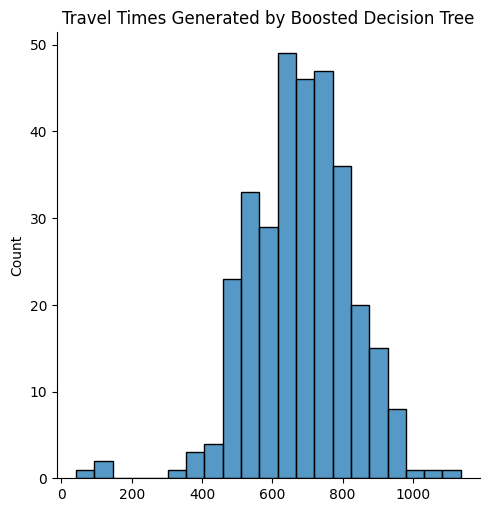

In [134]:
import seaborn as sns
ids = test_x["TRIP_ID"].values
# print(ids)
for i in range(len(y_pred)):
    y_pred[i] = y_pred[i] - 75
d = {"TRIP_ID" : ids, "TRAVEL_TIME" : y_pred}
newdf = pd.DataFrame(d)
# print(newdf)
newdf.to_csv("another_tree_max_depth3.csv", index=None)
labels = y_pred
# print(labels)
print('mean', np.mean(labels))
print('std', np.std(labels))
print('median', np.median(labels))
print('min', np.min(labels))
print('max', np.max(labels))
print('----------')
sns.displot(labels).set(title='Travel Times Generated by Boosted Decision Tree')



### Do some Feature Analysis

For our feature analysis, we are looking at which of our engineered features may be useful in making a taxicab time regression model

Using: 1656255/1656255


KeyError: ['YR']

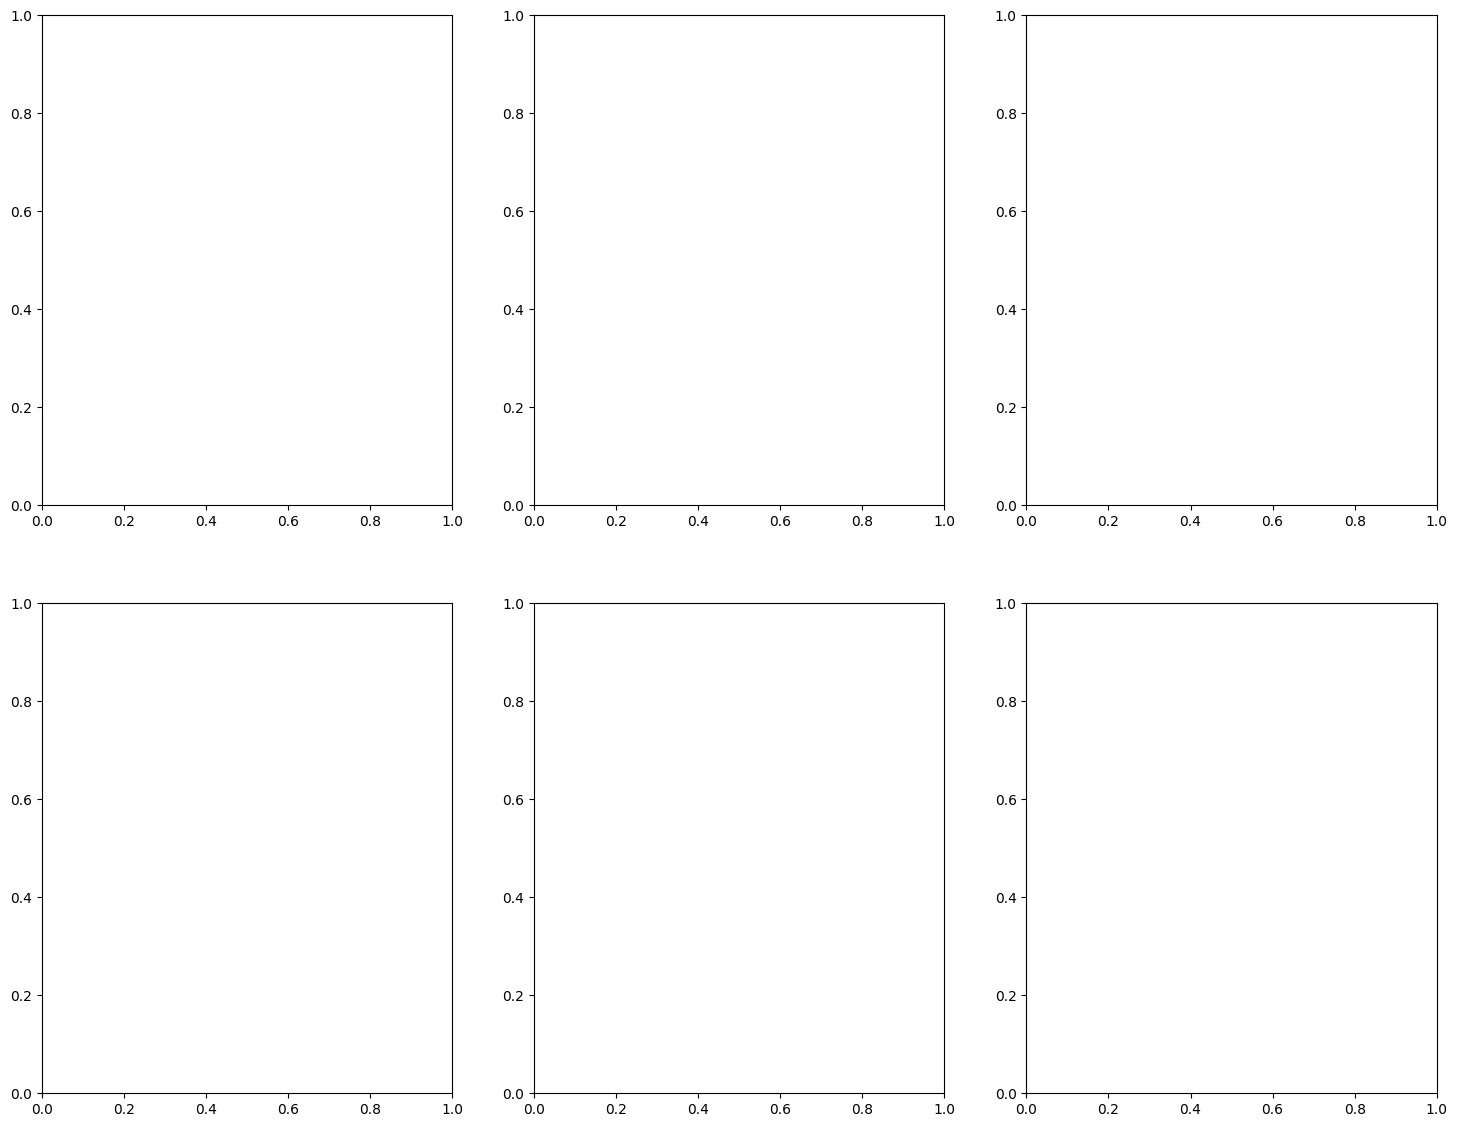

In [90]:
# First n samples to analyze. Set to -1 to use all data
end = -1

outlier_threshold = 3

# "Choose all data, where the trip length is less than 3 standard deviations away from the mean"
# This is to remove outliers. Otherwise, our plots would look very squished (since there are some
# VERRRRRY long taxi trips in the dataset)
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

# Because our y-values only take on multiples of 15, we want just enough buckets in a histogram
# such that each buckets counts one value's frequency. (e.x. one bucket counts how many 15s trips, 
# how many 30s trips, etc. )
buckets = (int(mean + outlier_threshold * std) // 15)

print(f"Using: {len(df_trimmed)}/{len(df_tr)}")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,14))

# Now, we visualize some features that we think might be useful
for idx, v in enumerate(["YR", "MON", "DAY", "HR", "WK", "ORIGIN_STAND"]):
  # idx // 3 = row, idx % 3 = column
  ax = axs[idx // 3, idx % 3]
  
  # Remove any rows with invalid values
  df_subset = df_trimmed.dropna(subset=v)
  
  # Create a histogram. Look up the documentation for more details
  ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))
  
  # Some stylistic things to make the graphs look nice
  ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
  ax.set_facecolor("black")
  ax.set_ylabel("seconds", fontsize=18)
  ax.set_title(f"Feature: {v}", fontsize=20)


In [ ]:
plt.figure(figsize=(10,10))
for v in [0, 5, 11, 17, 23]:
  # Filter data where the HR matches v
  hourly_data = df_trimmed[df_trimmed["HR"] == v]["LEN"]
  histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
  histogram = histogram / len(hourly_data)
  # The center is the left_bound and right_bound of a bucket
  bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
  plt.plot(bin_centers, histogram, label=f"HR={v}")
plt.legend();